In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
class MNISTDescriminator(nn.Module):
    def __init__(self):
        super(MNISTDescriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.sigmoid(x)
        return output

In [4]:
class MNISTGenerator(nn.Module):
    def __init__(self):
        super(MNISTGenerator, self).__init__()
        self.fc1 = nn.Linear(10, 128)
        self.fc2 = nn.Linear(128, 64 * 24 * 24)
        self.conv1 = nn.ConvTranspose2d(64, 32, 3, 1)
        self.conv2 = nn.ConvTranspose2d(32, 1, 3, 1)
    
    # x = (B,)
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = x.reshape(-1, 64, 24, 24)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        output = F.relu(x)
        return output

In [5]:
def train(
    classifier,
    descriminator,
    generator, 
    device, 
    train_loader, 
    c_optimizer, 
    d_optimizer,
    g_optimizer, 
    epoch):

    classifier.train()
    generator.train()
    descriminator.train()
    
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         c_optimizer.zero_grad()
#         output = classifier(data)
#         loss = F.nll_loss(output, target)
#         loss.backward()
#         c_optimizer.step()
#         if batch_idx % 256 == 0:
#             print('C Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        
        g_output = generator(F.one_hot(target[[i*2 for i in range(target.shape[0] // 2)]], num_classes=10).to(torch.float32))
        d_data = data.clone()
        d_targets = torch.ones(target.shape).to(device)
        for i in range(target.shape[0] // 2):
            d_data[i * 2] = g_output[i]
            d_targets[i * 2] = 0
        
        d_output = descriminator(d_data)
        print(f"Desc out: {d_output.shape}")
        
        loss = F.cross_entropy(d_output, d_targets)
        loss.backward()
        g_optimizer.step()
        d_optimizer.step()
        
        if batch_idx % 256 == 0:
            print('D Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    classifier.eval()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target_oh = F.one_hot(target, num_classes=10).to(torch.float32)
        g_optimizer.zero_grad()
        output = classifier(generator(target_oh))
        loss = F.nll_loss(output, target)
        loss.backward()
        g_optimizer.step()
        if batch_idx % 40 == 0:
            print(f"Output: {output[0]}")
            print(f"Target: {target[0]}")
            print('G Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [21]:
train_kwargs = {'batch_size': 64}

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
dataset1 = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)

generator = MNISTGenerator()

for batch_idx, (data, target) in enumerate(train_loader):
    g_output = generator(F.one_hot(target[[i*2 for i in range(target.shape[0] // 2)]], num_classes=10).to(torch.float32))
    descriminator_inputs = data.clone()
    descriminator_outputs = torch.ones(target.shape)
    for i in range(target.shape[0] // 2):
        descriminator_inputs[i * 2] = g_output[i]
        descriminator_outputs[i * 2] = 0
    print(descriminator_inputs.shape)
    print(descriminator_outputs.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [ ]:
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()

torch.manual_seed(1)

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device {device}")

train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 1000}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('./data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('./data', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

classifier = MNISTClassifier().to(device)
c_optimizer = optim.Adadelta(classifier.parameters(), lr=1.0)

descriminator = MNISTDescriminator().to(device)
d_optimizer = optim.Adadelta(descriminator.parameters(), lr=1.0)

generator = MNISTGenerator().to(device)
g_optimizer = optim.Adadelta(generator.parameters(), lr=1.0)

c_scheduler = StepLR(c_optimizer, step_size=1, gamma=0.7)
d_scheduler = StepLR(d_optimizer, step_size=1, gamma=0.7)
g_scheduler = StepLR(g_optimizer, step_size=1, gamma=0.7)
for epoch in range(1, 15):
    train(classifier, descriminator, generator, device, train_loader, c_optimizer, d_optimizer, g_optimizer, epoch)
    c_scheduler.step()
    d_scheduler.step()
    g_scheduler.step()

In [145]:
import matplotlib.pyplot as plt

torch.Size([1, 1, 28, 28])
tensor([[  0.0000, -52.0672, -37.5959, -51.9427, -48.5821, -40.8631, -30.2392,
         -37.5313, -35.9553, -35.4101]], device='mps:0')


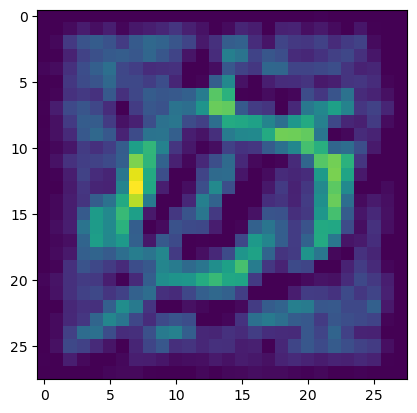

In [207]:
classifier.eval()
generator.eval()

with torch.no_grad():
    _x = torch.tensor([0]).to(device)
    x = F.one_hot(_x, num_classes=10).to(torch.float32).to(device)
    g_output = generator(x)
    print(g_output.shape)

    print(classifier(g_output))
    plt.imshow(g_output.cpu().data[0][0])